In [1]:
key = ''

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dropout, Dense, BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn import preprocessing
from collections import deque
import random
from datetime import datetime

In [4]:
import pandas_datareader.data as pdr
df = pdr.DataReader('AAPL','av-daily', api_key = key)

In [5]:
df.to_csv('AAPL.csv')

In [6]:
data = pd.read_csv('AAPL.csv')

In [7]:
data

,Unnamed: 0,open,high,low,close,volume
0,2000-12-27,14.34,14.81,14.190,14.810,5811900
1,2000-12-28,14.38,14.94,14.310,14.810,5449600
2,2000-12-29,14.69,15.00,14.500,14.880,11256000
3,2001-01-02,14.88,15.25,14.560,14.880,8077000
4,2001-01-03,14.50,16.69,14.440,16.370,14590600
...,...,...,...,...,...,...
5023,2020-12-15,124.34,127.90,124.130,127.880,157572262
5024,2020-12-16,127.41,128.37,126.560,127.810,98208591
5025,2020-12-17,128.90,129.58,128.045,128.700,94359811
5026,2020-12-18,128.96,129.10,126.120,126.655,192541496


In [8]:
#So in this data .. let's focus on close and volume columns.., and we'll set the date column as the index
data = data.rename(columns={'Unnamed: 0': 'Date'})

In [9]:
data

,Date,open,high,low,close,volume
0,2000-12-27,14.34,14.81,14.190,14.810,5811900
1,2000-12-28,14.38,14.94,14.310,14.810,5449600
2,2000-12-29,14.69,15.00,14.500,14.880,11256000
3,2001-01-02,14.88,15.25,14.560,14.880,8077000
4,2001-01-03,14.50,16.69,14.440,16.370,14590600
...,...,...,...,...,...,...
5023,2020-12-15,124.34,127.90,124.130,127.880,157572262
5024,2020-12-16,127.41,128.37,126.560,127.810,98208591
5025,2020-12-17,128.90,129.58,128.045,128.700,94359811
5026,2020-12-18,128.96,129.10,126.120,126.655,192541496


In [10]:
df = data[['Date', 'close', 'volume']]

In [11]:
df

,Date,close,volume
0,2000-12-27,14.810,5811900
1,2000-12-28,14.810,5449600
2,2000-12-29,14.880,11256000
3,2001-01-02,14.880,8077000
4,2001-01-03,16.370,14590600
...,...,...,...
5023,2020-12-15,127.880,157572262
5024,2020-12-16,127.810,98208591
5025,2020-12-17,128.700,94359811
5026,2020-12-18,126.655,192541496


In [12]:
#So looking at the target now.. we'll need some parameters which we can use in getting our target .. #Predictions..
#1. 
SEQ_LEN = 60  #Last 60 days of the the sequential data will be used for the prediction.
FUTURE_DAYS_PREDICT = 40 #Let's say we want to predict the price for the next 4 days.. 

In [13]:
df['future'] = df['close'].shift(-(FUTURE_DAYS_PREDICT))  #This is like the future price after ... days

In [14]:
df['future'].isnull().sum()

40

In [15]:
df

,Date,close,volume,future
0,2000-12-27,14.810,5811900,19.50
1,2000-12-28,14.810,5449600,19.37
2,2000-12-29,14.880,11256000,18.25
3,2001-01-02,14.880,8077000,18.75
4,2001-01-03,16.370,14590600,19.25
...,...,...,...,...
5023,2020-12-15,127.880,157572262,NaN
5024,2020-12-16,127.810,98208591,NaN
5025,2020-12-17,128.700,94359811,NaN
5026,2020-12-18,126.655,192541496,NaN


In [16]:
df.dropna(axis = 0, inplace = True)

In [17]:
df


,Date,close,volume,future
0,2000-12-27,14.81,5811900,19.500
1,2000-12-28,14.81,5449600,19.370
2,2000-12-29,14.88,11256000,18.250
3,2001-01-02,14.88,8077000,18.750
4,2001-01-03,16.37,14590600,19.250
...,...,...,...,...
4983,2020-10-19,115.98,120639337,127.880
4984,2020-10-20,117.51,124423728,127.810
4985,2020-10-21,116.87,89945980,128.700
4986,2020-10-22,115.75,101987954,126.655


In [18]:
#Data Preprocessing
#Out of samples, Normalize, scale the data, Create Sequences

#So we still have to create sequences normalize , scale the data .. e.t.c before we begin to train. 
#Data processing is very crucial in a Sequential data.
#So let's bring out our train and test.. but note in a sequential data.. we can't just bring out our train, test randomly coz it's a sequential data


In [19]:
#So for our out of samples.. 
times = sorted(df.index.values)
last_10pct = times[-int((0.25 * len(times)))]

In [20]:
train_df = df[df.index < last_10pct]
test_df = df[df.index >= last_10pct]
train_df_1 = df[df.index < last_10pct].copy()
test_df_1 = df[df.index >= last_10pct].copy()

In [21]:
train_df

,Date,close,volume,future
0,2000-12-27,14.81,5811900,19.50
1,2000-12-28,14.81,5449600,19.37
2,2000-12-29,14.88,11256000,18.25
3,2001-01-02,14.88,8077000,18.75
4,2001-01-03,16.37,14590600,19.25
...,...,...,...,...
3736,2015-11-04,122.00,44886050,105.35
3737,2015-11-05,120.92,39552680,102.71
3738,2015-11-06,121.06,33042283,100.70
3739,2015-11-09,120.57,33871405,96.45


In [22]:
def preprocess_df(df):
  df = df.drop(['future', 'volume'], axis=1)
  for col in df.columns:
    if col == 'close':        #Since we are not normalizing target column
      df[col] = df[col].pct_change()
      df.dropna(inplace = True)
      df[col] = preprocessing.scale(df[col].values)  #Scaling the data... 
  df.dropna(inplace=True)
  return df

train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)


In [23]:
train_df = np.array(train_df['close'])
test_df = np.array(test_df['close'])

In [24]:
len(test_df)

1246

In [25]:
#so let's create our sequential data
def create_dataset(dataset, time_step = 1):
  data_x , data_y = [], []
  for i in range(len(dataset)-time_step-1):
    end_ix = i + time_step
    a = dataset[i:end_ix]
    data_x.append(a), data_y.append(dataset[end_ix])
  return np.array(data_x), np.array(data_y)

time_step = 60
X_train, Y_train = create_dataset(train_df, time_step)
X_test,  Y_test = create_dataset(test_df, time_step)
    

In [26]:
X_train = X_train.reshape(len(X_train), 60, 1)
X_test = X_test.reshape(len(X_test), 60, 1)

In [27]:
model = Sequential()
model.add(LSTM(units = 128, input_shape = X_train.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(units = 128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(units = 128, return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'mse')


In [28]:
History = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size = 64, epochs = 100, verbose = 1)

Epoch 1/100
58/58 [==============================] - 11s 34ms/step - loss: 1.6273 - val_loss: 1.0769
Epoch 2/100
58/58 [==============================] - 1s 18ms/step - loss: 0.7415 - val_loss: 1.0338
Epoch 3/100
58/58 [==============================] - 1s 16ms/step - loss: 1.0440 - val_loss: 1.0270
Epoch 4/100
58/58 [==============================] - 1s 16ms/step - loss: 1.0507 - val_loss: 1.0261
Epoch 5/100
58/58 [==============================] - 1s 16ms/step - loss: 0.9498 - val_loss: 1.0259
Epoch 6/100
58/58 [==============================] - 1s 16ms/step - loss: 1.3341 - val_loss: 1.0260
Epoch 7/100
58/58 [==============================] - 1s 16ms/step - loss: 0.7142 - val_loss: 1.0259
Epoch 8/100
58/58 [==============================] - 1s 16ms/step - loss: 0.7220 - val_loss: 1.0259
Epoch 9/100
58/58 [==============================] - 1s 16ms/step - loss: 1.1172 - val_loss: 1.0260
Epoch 10/100
58/58 [==============================] - 1s 16ms/step - loss: 1.1520 - val_loss: 1.025

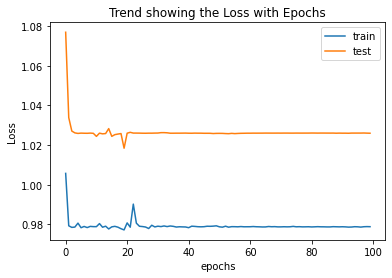

In [29]:
#Let's plot the trend.
import matplotlib.pyplot as plt
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'best')
plt.title('Trend showing the Loss with Epochs')
plt.show()

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               1

In [31]:
model.save('StockPrice.h5')
train_predict = model.predict(X_train)

In [32]:
from sklearn.metrics import mean_squared_error
import math

In [33]:
train_predict = np.round(train_predict)

In [34]:
math.sqrt(mean_squared_error(Y_train, train_predict))

0.9893205276530792

In [35]:
test_predict = model.predict(X_test)
test_predict = np.round(test_predict)
math.sqrt(mean_squared_error(Y_test, test_predict))

1.0129298626769263

In [36]:
#So were using this last 60 days of the test data for our future prediction.
from sklearn.preprocessing import MinMaxScaler
test_df_1 = test_df_1['close']
scaler = MinMaxScaler(feature_range=(0,1))
input_data = scaler.fit_transform(np.array(test_df_1[1187:]).reshape(-1,1))

In [37]:
#Predict for the next 40 days
list_output = []
FUTURE_DAYS_PREDICT = 40 
SEQ_LEN = 60
i = 0

while i < FUTURE_DAYS_PREDICT:
  if len(input_data) <= SEQ_LEN:  #0 day
    input_data = input_data.reshape((1, SEQ_LEN, 1))
    yhat = model.predict(input_data, verbose = 0)
    print(yhat[0])
    input_data = np.append(input_data, yhat[0])
    print(len(input_data))
    list_output.append(yhat[0][0])
    temp_input = input_data[1:]
    i += 1

  else:
    print(f"{i} day input {temp_input}")
    temp_input = temp_input.reshape((1, SEQ_LEN, 1))
    yhat = model.predict(temp_input, verbose = 0)
    print(f"{i} day output {yhat}")
    temp_input = np.append(temp_input, yhat[0])
    print(len(temp_input))
    temp_input = temp_input[1:]
    list_output.append(yhat[0][0])
    i += 1

print(list_output)
    
  



  
    



[0.0056541]
61
1 day input [8.23819662e-01 8.31108328e-01 8.35090795e-01 8.73562930e-01
 8.45610520e-01 8.61790858e-01 8.28202880e-01 8.64621165e-01
 8.84658735e-01 8.83631810e-01 8.80626174e-01 8.90194114e-01
 8.91646838e-01 9.17370069e-01 9.78434565e-01 9.93337508e-01
 9.82993112e-01 1.00000000e+00 9.84846587e-01 9.82817783e-01
 5.56042580e-02 6.84783970e-02 6.15153413e-02 3.51659361e-02
 3.53663118e-02 1.49780839e-02 2.62492173e-02 1.66562304e-02
 1.29242329e-02 2.13274890e-02 2.17908579e-02 1.32498435e-02
 8.76643707e-03 0.00000000e+00 8.11521603e-03 1.24483406e-02
 7.01314966e-04 3.45648090e-03 1.36255479e-02 2.03381340e-02
 1.81590482e-02 2.24671259e-02 2.49217282e-02 1.54790232e-02
 2.41953663e-02 1.58296807e-02 2.06386976e-02 2.03631810e-02
 2.53725736e-02 4.39824671e-02 3.57169693e-02 3.59423920e-02
 3.47401378e-02 3.05072010e-02 2.28929242e-02 2.67251096e-02
 2.51221039e-02 2.23168441e-02 2.05385097e-02 5.65410405e-03]
1 day output [[0.0056576]]
61
2 day input [8.31108328e-01

In [38]:
#Let's visualize it
pred_day = scaler.inverse_transform(np.array(list_output).reshape(-1,1))

In [39]:
pred_day

array([[109.0974  ],
       [109.0988  ],
       [109.09918 ],
       [109.09941 ],
       [109.099724],
       [109.09988 ],
       [109.09979 ],
       [109.09954 ],
       [109.099174],
       [109.09879 ],
       [109.09853 ],
       [109.09854 ],
       [109.09886 ],
       [109.09945 ],
       [109.10018 ],
       [109.10098 ],
       [109.10177 ],
       [109.102455],
       [109.10297 ],
       [109.10326 ],
       [109.1033  ],
       [109.103096],
       [109.103096],
       [109.10309 ],
       [109.10307 ],
       [109.103065],
       [109.103065],
       [109.10307 ],
       [109.10309 ],
       [109.103096],
       [109.103096],
       [109.103096],
       [109.10307 ],
       [109.10305 ],
       [109.10303 ],
       [109.10303 ],
       [109.10303 ],
       [109.10303 ],
       [109.10304 ],
       [109.10305 ]], dtype=float32)

In [40]:
day_new = np.arange(1, 61)
day_pred = np.arange(61, 101)

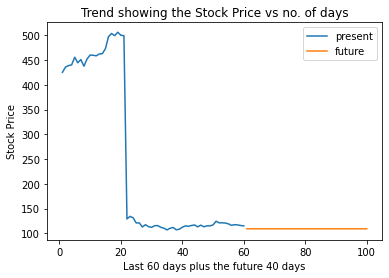

In [41]:
plt.plot(day_new, np.array(test_df_1[1187:]))
plt.plot(day_pred, pred_day)
plt.xlabel('Last 60 days plus the future 40 days')
plt.ylabel('Stock Price')
plt.legend(['present', 'future'], loc = 'best')
plt.title('Trend showing the Stock Price vs no. of days')
plt.show()
